# Specinsure
# Monte Carlo Simulation of XoL Reinsurance in Specialty Insurance

# Author: Goabaone Sehurutshe
# Date: 2025-06-16

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pareto, expon, lognorm

# For pretty plots
sns.set_theme(style="whitegrid")
np.random.seed(42)

We use the lognormal distribution to model severities mainly for the following reasons:
- It is strictly positive since claims cannot be negative this propertly is preserved
- There is empirical evidence to support the modelling of losses, especially for non-cat attritional claims

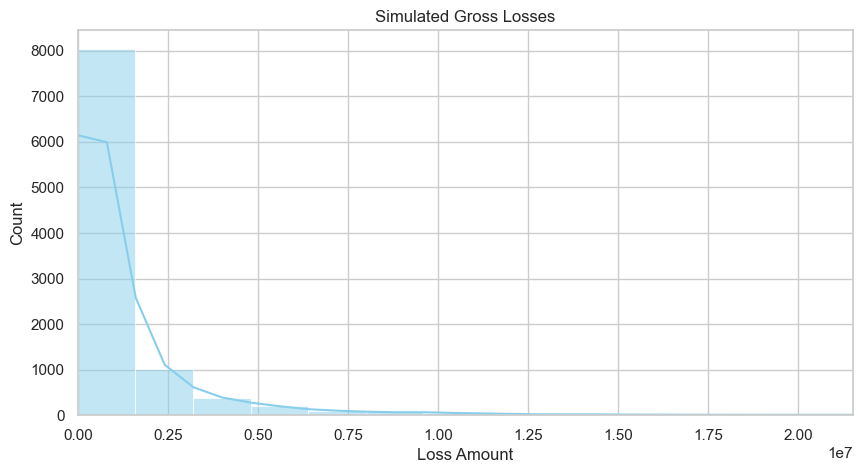

In [ ]:
n_simulations = 10_000

mean_severity = 13  
std_severity = 1.5  

gross_losses = np.random.lognormal(mean_severity, std_severity, n_simulations)

# Visualize distribution
plt.figure(figsize=(10, 5))
sns.histplot(gross_losses, bins=100, kde=True, color="skyblue")
plt.title("Simulated Gross Losses")
plt.xlabel("Loss Amount")
plt.xlim(0, np.percentile(gross_losses, 99.5))  
plt.show()

Other distributions that can be used are:
- The pareto - Generalised Pareto which is suitable for modelling catastrophe or heavy tailed losses
- The exponential distribution may also be used for small/medium basic modelling of severities

### Comparison of the Lognormal, Exponential and Pareto 

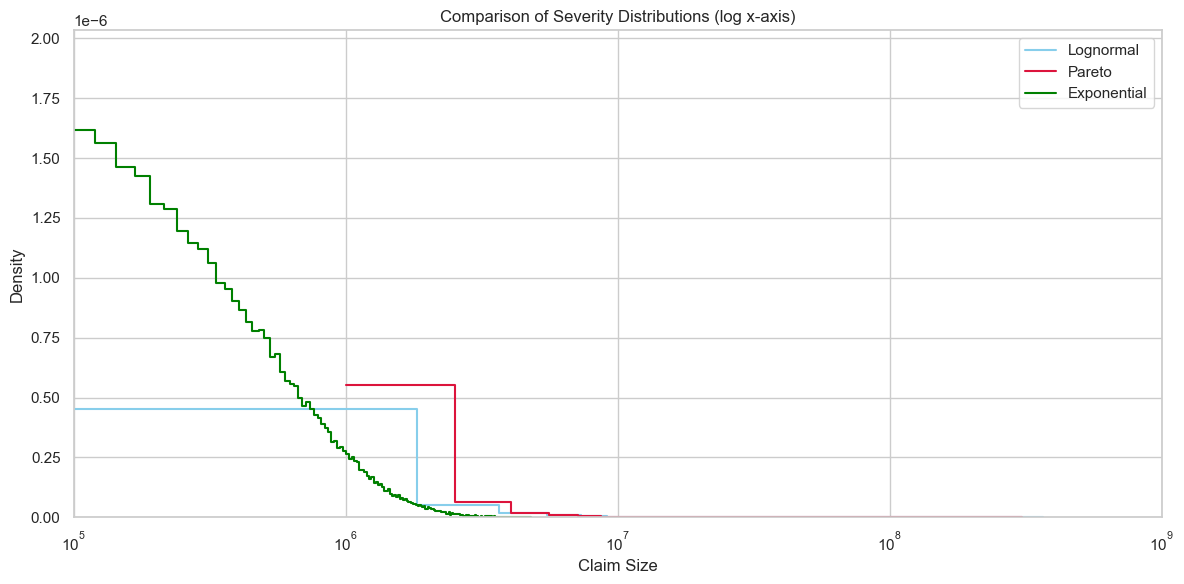

In [6]:
n = 100_000

# -------------------------------
# Generate samples
# -------------------------------

# Lognormal: moderate tail
lognormal_samples = np.random.lognormal(mean=13, sigma=1.5, size=n)

# Pareto: heavy tail
pareto_shape = 2.0  
pareto_samples = pareto.rvs(b=pareto_shape, scale=1e6, size=n)  

# Exponential: thin tail
expon_samples = expon.rvs(scale=5e5, size=n)  
# -------------------------------
# Plotting
# -------------------------------

plt.figure(figsize=(12, 6))

# Histogram with log-scale x-axis
sns.histplot(lognormal_samples, label="Lognormal", color="skyblue", bins=200, stat="density", element="step", fill=False)
sns.histplot(pareto_samples, label="Pareto", color="crimson", bins=200, stat="density", element="step", fill=False)
sns.histplot(expon_samples, label="Exponential", color="green", bins=200, stat="density", element="step", fill=False)

plt.xscale("log")
plt.title("Comparison of Severity Distributions (log x-axis)")
plt.xlabel("Claim Size")
plt.ylabel("Density")
plt.legend()
plt.xlim(1e5, 1e9)
plt.tight_layout()
plt.show()

Because of the way in which these distributions are different and have various relationships
It is not uncommon to find modelling in reinsurance modelling where we use the Lognormal distribution to model attritional losses and claims contained to the primary layer
The Pareto will then be used to model losses in the excess layers
This combination of the two is very common and in that it combines the two attributes of these distributions
- Allowing for attritional losses 
- Allowing for large losses

In [7]:
attachment_point = 1_000_000
limit = 5_000_000

def apply_xol(losses, attachment, limit):
    return np.minimum(np.maximum(losses - attachment, 0), limit)

reinsured_losses = apply_xol(gross_losses, attachment_point, limit)
net_retained = gross_losses - reinsured_losses

In [8]:
# Summary statistics
df = pd.DataFrame({
    'Gross Loss': gross_losses,
    'Reinsurance Recovery': reinsured_losses,
    'Net Retained': net_retained
})

df.describe(percentiles=[0.5, 0.95, 0.99])

,Gross Loss,Reinsurance Recovery,Net Retained
count,1.000000e+04,1.000000e+04,1.000000e+04
mean,1.375660e+06,5.331986e+05,8.424616e+05
std,3.957391e+06,1.243515e+06,3.279304e+06
min,1.232007e+03,0.000000e+00,1.232007e+03
50%,4.406947e+05,0.000000e+00,4.406947e+05
95%,5.199444e+06,4.199444e+06,1.000000e+06
99%,1.446507e+07,5.000000e+06,9.465069e+06
max,1.597877e+08,5.000000e+06,1.547877e+08


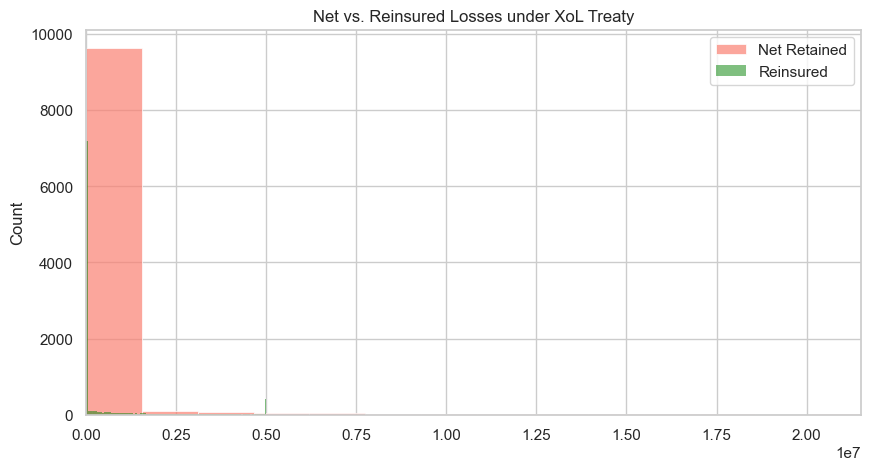

In [9]:
# Plot retention vs ceded
plt.figure(figsize=(10, 5))
sns.histplot(net_retained, bins=100, color="salmon", label="Net Retained", alpha=0.7)
sns.histplot(reinsured_losses, bins=100, color="green", label="Reinsured", alpha=0.5)
plt.xlim(0, np.percentile(gross_losses, 99.5))
plt.title("Net vs. Reinsured Losses under XoL Treaty")
plt.legend()
plt.show()

In [10]:

print(f"Average Gross Loss: ${np.mean(gross_losses):,.0f}")
print(f"Average Reinsured Recovery: ${np.mean(reinsured_losses):,.0f}")
print(f"Average Net Retention: ${np.mean(net_retained):,.0f}")
print(f"Reinsurer share: {np.mean(reinsured_losses) / np.mean(gross_losses):.2%}")

Average Gross Loss: $1,375,660
Average Reinsured Recovery: $533,199
Average Net Retention: $842,462
Reinsurer share: 38.76%
